# Analiza spożycia używek 

In [1]:
# importowanie potrzebnych bibliotek
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import graphviz

from scipy import stats
from sklearn import tree
from sklearn import metrics
from sklearn.decomposition import PCA
from wand.image import Image as WImage
from IPython.display import IFrame


%matplotlib inline 

## Wczytanie i obróbka danych 

In [2]:
# wczytanie danych 
data = pd.read_csv('drug.txt', sep = ' ')

# zamienienie kolumn z informacja o spozyciu uzywek na dane liczbowe
for i in data.columns[12:31]:
    data[[i]] = data[i].str.extract('(\d+)')

data.iloc[:,12:31] = data.iloc[:,12:31].apply(pd.to_numeric)

In [3]:
dic_educ_mapping = {-2.436: 'Left school <=18',
                    -1.738: 'Left school <=18',
                    -1.437: 'Left school <=18',
                    -1.228: 'Left school <=18',
                    -0.611: 'Some college or university',
                    -0.059: 'Professional certificate',
                    0.455: 'Professional certificate',
                    1.164: 'Professional certificate',
                    1.984: 'PhD'}

dic_country_mapping = {0.961: 'UK', 
                        0.249: 'Canada', 
                        -0.570: 'USA', 
                        -0.285: 'Other', 
                        -0.098: 'Australia', 
                        0.211: 'Republic of Ireland', 
                        -0.468: 'New Zealand'}

dic_age_mapping = {-0.952: '18-24',
                    -0.079: '25-34',
                    0.498: '35-44',
                    1.094: '45-54',
                    1.822: '55-64',
                    2.592: '65+'}

dic_gender_mapping = {0.482:'Female',
                      -0.482: 'Male'}


data['Education_mapped']= data['Education'].round(3).map(dic_educ_mapping)
data['Country_mapped']= data['Country'].round(3).map(dic_country_mapping)
data['Age_mapped']= data['Age'].round(3).map(dic_age_mapping)
data['Gender_mapped'] = data['Gender'].round(3).map(dic_gender_mapping)

## Statystyki opisowe 

In [4]:
# Podgląd danych 
data.head(3)

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,LSD,Metadon,Grzyby,Nicotyna,Semeron,Inne_substancje_lotne,Education_mapped,Country_mapped,Age_mapped,Gender_mapped
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,2,0,0,Professional certificate,UK,35-44,Female
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,2,3,0,4,0,0,PhD,UK,25-34,Male
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,1,0,0,0,Professional certificate,UK,35-44,Male


In [5]:
data.tail(3)

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,LSD,Metadon,Grzyby,Nicotyna,Semeron,Inne_substancje_lotne,Education_mapped,Country_mapped,Age_mapped,Gender_mapped
1882,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,...,2,0,2,6,0,0,Professional certificate,USA,25-34,Female
1883,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,-2.57309,...,3,0,3,4,0,0,Some college or university,USA,18-24,Female
1884,-0.95197,-0.48246,-0.61113,0.21128,-0.31685,-0.46725,2.12700,1.65653,1.11406,0.41594,...,3,0,3,6,0,2,Some college or university,Republic of Ireland,18-24,Male


In [6]:
data.columns

Index(['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore',
       'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'Alkohol',
       'Amfetamina', 'Azotyn_amylu', 'Benzodiazepina', 'Kofeina', 'Marihuana',
       'Czekolada', 'Kokaina', 'Crack', 'Ecstasy', 'Heroina', 'Ketamina',
       'Dopalacze', 'LSD', 'Metadon', 'Grzyby', 'Nicotyna', 'Semeron',
       'Inne_substancje_lotne', 'Education_mapped', 'Country_mapped',
       'Age_mapped', 'Gender_mapped'],
      dtype='object')

Dane podzielone są na dwie części: pierwsza dotyczy pochodzenia, wieku, płci, wykształcenia i osobowości respondenta.
Druga część dotyczy spożywania 19 legalnych i nielegalnych używek (alkohol, amfetamina, azotyn amylu, benzodiazepina, marihuana, czekolada, kokaina, kofeina, crack, ecstasy, heroina, ketamina, dopalacze, LSD, metadon, grzyby, nikotyna i inne substancje lotne oraz jeden fikcyjny lek (Semeron))
- CL0 - nigdy niezażywany,
- CL1 - zażyty ponad 10 lat temu,
- CL2 - zażyty w ciągu ostatnich 10 lat,
- CL3 - zażyty w ciągu ostatniego roku,
- CL4 - zażyty w ciągu ostatniego miesiąca,
- CL5 - zażyty w ciągu ostatniego tygodnia,
- CL6 - zażyty w ciągu ostatniego dnia.

Wartości dotyczące spożycia używek zostały przemapowane na liczby (CL0 -> 0, CL1 -> 1, itd.).

In [7]:
# rozmiar danych 
data.shape

(1885, 35)

In [8]:
# sprawdzenie wartosci brakujacych 
data.isna().sum().to_frame()

,0
Age,0
Gender,0
Education,0
Country,0
Ethnicity,0
Nscore,0
Escore,0
Oscore,0
Ascore,0
Cscore,0


In [9]:
# Statystyki opsiowe dla 
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1885.0,0.034610,0.878360,-0.95197,-0.95197,-0.07854,0.49788,2.59171
Gender,1885.0,-0.000256,0.482588,-0.48246,-0.48246,-0.48246,0.48246,0.48246
Education,1885.0,-0.003806,0.950078,-2.43591,-0.61113,-0.05921,0.45468,1.98437
Country,1885.0,0.355542,0.700335,-0.57009,-0.57009,0.96082,0.96082,0.96082
Ethnicity,1885.0,-0.309577,0.166226,-1.10702,-0.31685,-0.31685,-0.31685,1.90725
Nscore,1885.0,0.000047,0.998106,-3.46436,-0.67825,0.04257,0.62967,3.27393
Escore,1885.0,-0.000163,0.997448,-3.27393,-0.69509,0.00332,0.63779,3.27393
Oscore,1885.0,-0.000534,0.996229,-3.27393,-0.71727,-0.01928,0.72330,2.90161
Ascore,1885.0,-0.000245,0.997440,-3.46436,-0.60633,-0.01729,0.76096,3.46436
Cscore,1885.0,-0.000386,0.997523,-3.46436,-0.65253,-0.00665,0.58489,3.46436


In [10]:
# Outliers - obserwacje z bardzo niską lub bardzo wysoką sumą spożycia używek
# Oj, klamczuszki! 
data['Suma']=data.iloc[:,12:31].sum(axis = 1)
data[(data.Suma <10) | (data.Suma >70)].sort_values(by = 'Suma')

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,Metadon,Grzyby,Nicotyna,Semeron,Inne_substancje_lotne,Education_mapped,Country_mapped,Age_mapped,Gender_mapped,Suma
1277,-0.95197,-0.48246,0.45468,0.96082,-0.50212,0.82562,0.63779,-0.84732,-2.21844,0.93949,...,0,0,0,0,0,Professional certificate,UK,18-24,Male,0
1743,0.49788,0.48246,1.16365,0.96082,-1.10702,-0.24649,-0.57545,-0.58331,0.13136,0.12331,...,0,0,0,0,0,Professional certificate,UK,35-44,Female,1
383,1.09449,0.48246,0.45468,0.96082,-1.10702,-0.24649,0.16767,-0.97631,0.76096,0.58489,...,0,0,0,0,0,Professional certificate,UK,45-54,Female,5
386,-0.07854,-0.48246,0.45468,0.96082,-1.10702,-1.32828,0.32197,-0.58331,-1.34289,2.04506,...,0,0,0,0,0,Professional certificate,UK,25-34,Male,5
13,1.82213,0.48246,-0.05921,0.24923,-0.31685,-0.79151,0.80523,-0.01928,0.94156,3.46436,...,0,0,1,0,0,Professional certificate,Canada,55-64,Female,7
128,0.49788,-0.48246,1.98437,0.96082,-0.50212,0.04257,0.63779,0.14143,0.13136,0.25953,...,0,0,1,0,0,PhD,UK,35-44,Male,7
377,-0.07854,-0.48246,1.16365,-0.28519,-0.31685,0.82562,-0.94779,0.58331,0.59042,0.75830,...,0,0,0,0,0,Professional certificate,Other,25-34,Male,8
973,2.59171,-0.48246,1.16365,-0.57009,-0.31685,-2.21844,0.00332,0.58331,0.76096,0.75830,...,0,0,1,0,0,Professional certificate,USA,65+,Male,8
66,1.09449,-0.48246,-1.73790,0.96082,-0.31685,-1.05308,-0.69509,-1.11902,1.28610,0.41594,...,0,0,0,0,0,Left school <=18,UK,45-54,Male,9
182,0.49788,0.48246,-0.61113,0.96082,-0.31685,0.31287,0.80523,-0.31776,1.28610,0.75830,...,0,0,0,0,0,Some college or university,UK,35-44,Female,9


In [11]:
data[(data.Suma <10) | (data.Suma >70)].sort_values(by = 'Suma').iloc[[0,-1],:].T

,1277,898
Age,-0.95197,-0.95197
Gender,-0.48246,-0.48246
Education,0.45468,0.45468
Country,0.96082,0.24923
Ethnicity,-0.50212,-0.31685
Nscore,0.82562,-2.52197
Escore,0.63779,1.74091
Oscore,-0.84732,-1.55521
Ascore,-2.21844,-3.46436
Cscore,0.93949,-0.14277


## Przedstawienie danych dotyczących respondentów w formie tabel i pie-chartów

In [12]:
# pomocnicza funkcja do wykresów 
def plocik(dane, columna):
    fig, ax = plt.subplots(figsize=(15,7)) 
    dane[columna].plot.pie(autopct='%1.1f%%', 
                             colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 
                                       'lightpink', 'crimson', 'khaki', 'tan', 'ivory'])
    plt.axis('equal')
    plt.show()

In [13]:
# WIEK 
age = pd.DataFrame(data.Age.value_counts().values, ['18-24', '25-34' , '35-44' , '45-54', '55-64' , '65+'], columns=['Age'])
age

,Age
18-24,643
25-34,481
35-44,356
45-54,294
55-64,93
65+,18


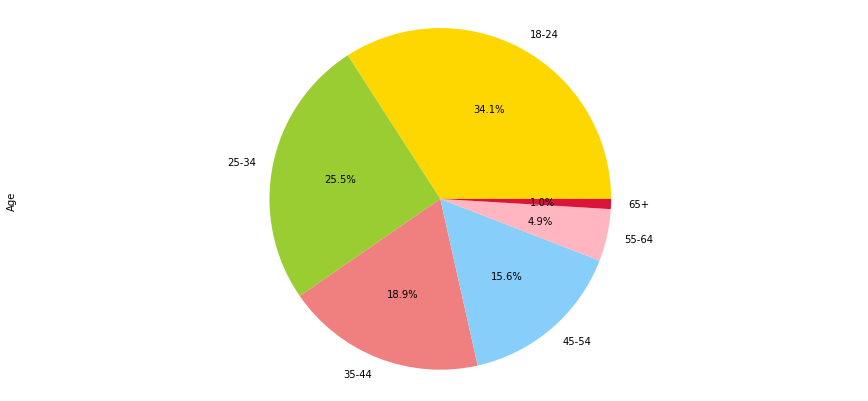

In [14]:
plocik(age, 'Age')

In [15]:
# PŁEĆ
gender = pd.DataFrame(data.Gender.value_counts().values, ['Male', 'Female' ], columns=['Gender'])
gender

,Gender
Male,943
Female,942


In [16]:
# EDUKACJA
education = pd.DataFrame(data.Education.value_counts().values, 
                         ['Some college or university, no certificate or degree', 
                         'University degree','Msters degree', 'Professional certificate/ diploma',
                         'Left school at 18 years', 'Left school at 16 years', 'Doctorate degree',
                         'Left school at 17 years', 'Left school before 16 years'], 
                         columns=['Education'])
education

,Education
"Some college or university, no certificate or degree",506
University degree,480
Msters degree,283
Professional certificate/ diploma,270
Left school at 18 years,100
Left school at 16 years,99
Doctorate degree,89
Left school at 17 years,30
Left school before 16 years,28


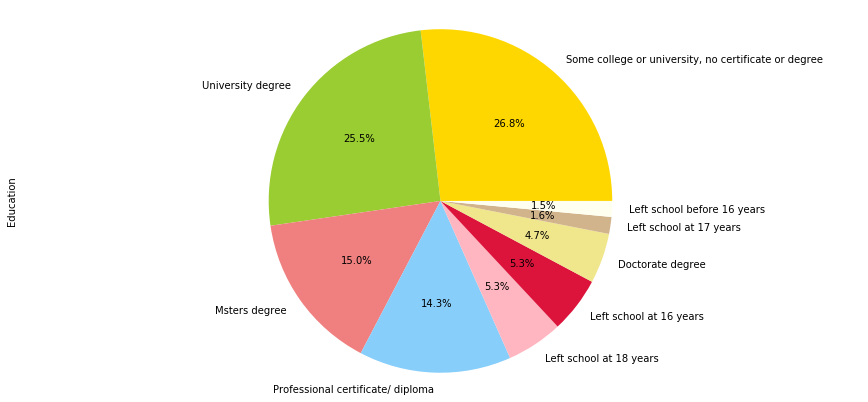

In [17]:
plocik(education, "Education")

In [18]:
# EDUKACJA
education_mapped = pd.DataFrame(data.Education_mapped.value_counts())
education_mapped

,Education_mapped
Professional certificate,1033
Some college or university,506
Left school <=18,257
PhD,89


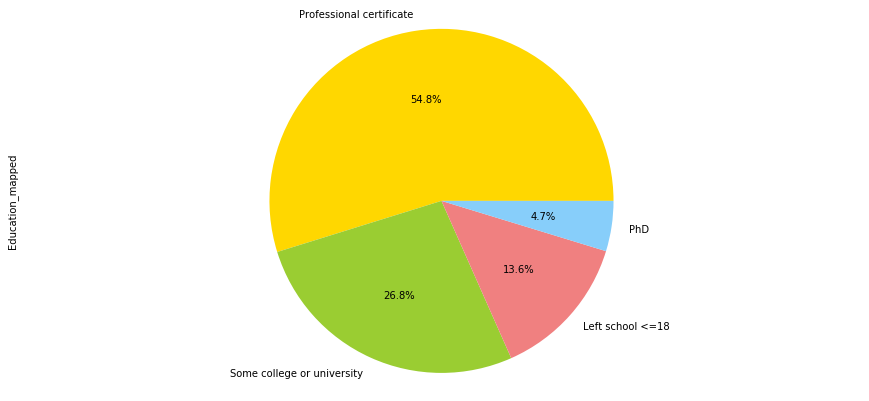

In [19]:
plocik(education_mapped, 'Education_mapped')

In [20]:
# KRAJE
country = pd.DataFrame(data.Country.value_counts().values, 
                         ['UK', 
                         'USA','Other', 'Canada',
                         'Australia', 'Republic of Ireland', 'New Zealand'], 
                         columns=['Country'])
country

,Country
UK,1044
USA,557
Other,118
Canada,87
Australia,54
Republic of Ireland,20
New Zealand,5


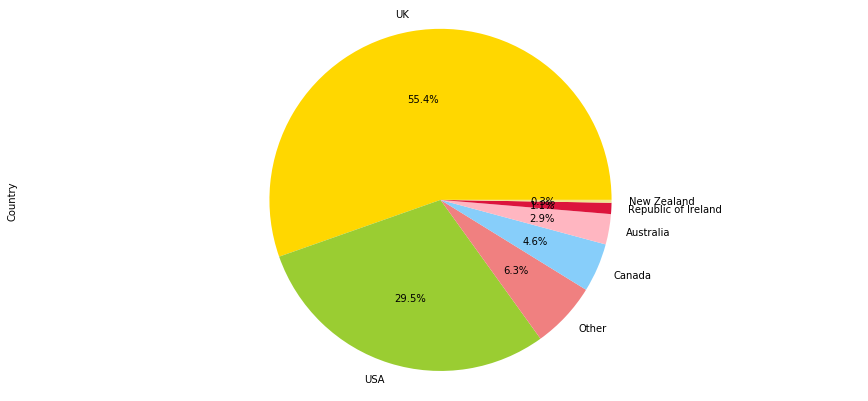

In [21]:
plocik(country, 'Country')

In [22]:
eth = pd.DataFrame(data.Ethnicity.value_counts().values, 
                         ['White', 
                         'Other', 'Black',
                         'Asian', 'Mixed-White/Black', 'Mixed-White/Asian', 'Mixed-Black/Asian'], 
                         columns=['Ethnicity'])
eth

,Ethnicity
White,1720
Other,63
Black,33
Asian,26
Mixed-White/Black,20
Mixed-White/Asian,20
Mixed-Black/Asian,3


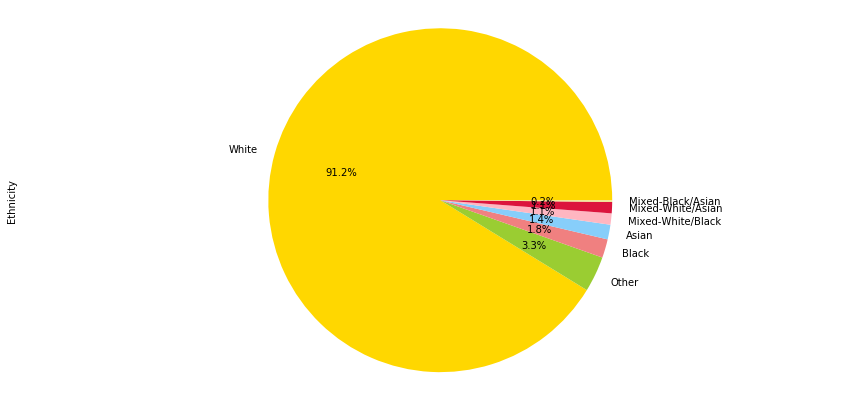

In [23]:
plocik(eth, 'Ethnicity')

## Redukacja wymiarowości 

In [24]:
# PCA na zmiennych dot. osobowości respondentów 

In [46]:
# zmienne uprzednio już wystandaryzowane (mean ~ 0, sd ~ 1)
to_PCA = data[['Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']]
# zmienne są średnio skorelowane
to_PCA.corr()

,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS
Nscore,1.000000,-0.431051,0.010177,-0.216964,-0.391088,0.174399,0.079988
Escore,-0.431051,1.000000,0.245277,0.157336,0.308024,0.114151,0.210130
Oscore,0.010177,0.245277,1.000000,0.038516,-0.056811,0.277512,0.421709
Ascore,-0.216964,0.157336,0.038516,1.000000,0.247482,-0.229690,-0.208061
Cscore,-0.391088,0.308024,-0.056811,0.247482,1.000000,-0.335133,-0.229038
Impulsive,0.174399,0.114151,0.277512,-0.229690,-0.335133,1.000000,0.623120
SS,0.079988,0.210130,0.421709,-0.208061,-0.229038,0.623120,1.000000


In [47]:
# pca 
pca = PCA()
principalComponents = pca.fit_transform(to_PCA)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1', 'principal component 2', 
                                     'principal component 3', 'principal component 4', 
                                     'principal component 5', 'principal component 6', 
                                     'principal component 7'])

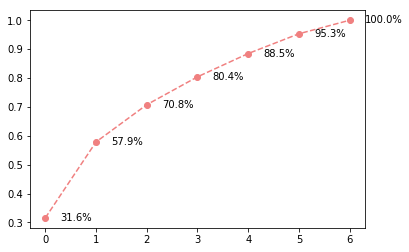

In [48]:
pca_cumsum = pca.explained_variance_ratio_.cumsum()
plt.plot(pca_cumsum, linestyle='--', marker='o', color='lightcoral', label = True)
for i, j in enumerate(pca_cumsum):
    plt.annotate(str(100*round(j,3))+ '%', (i+0.3, j-0.01))

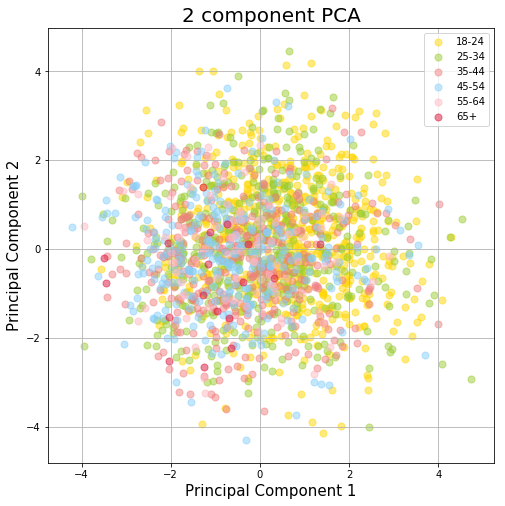

In [49]:
after_PCA = pd.concat([principalDf, data[['Age_mapped']]], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 
                                       'lightpink', 'crimson', 'khaki', 'tan', 'ivory']

for target, color in zip(targets,colors):
    indicesToKeep = after_PCA['Age_mapped'] == target
    ax.scatter(after_PCA.loc[indicesToKeep, 'principal component 1']
               , after_PCA.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50, 
              alpha = 0.5)
ax.legend(targets)
ax.grid()

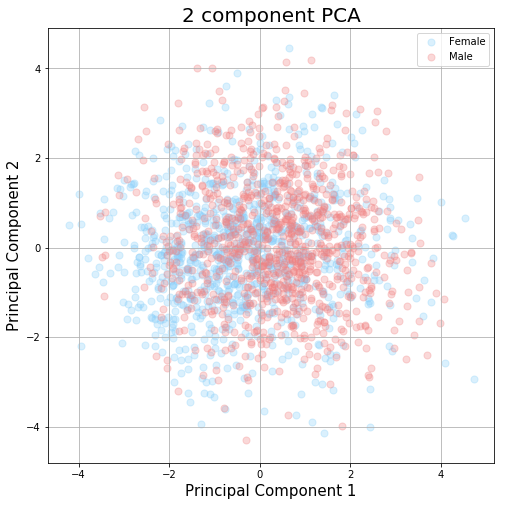

In [50]:
after_PCA = pd.concat([principalDf, data[['Gender_mapped']]], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['Female', "Male"]
colors = ['lightskyblue', 'lightcoral']

for target, color in zip(targets,colors):
    indicesToKeep = after_PCA['Gender_mapped'] == target
    ax.scatter(after_PCA.loc[indicesToKeep, 'principal component 1']
               , after_PCA.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50, alpha = 0.3)
ax.legend(targets)
ax.grid()

In [57]:
after_PCA.groupby('Gender_mapped').mean()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7
Gender_mapped,,,,,,,
Female,-0.359273,-0.097496,-0.122778,0.001700,0.147579,0.110004,-0.033439
Male,0.358892,0.097393,0.122648,-0.001698,-0.147423,-0.109888,0.033404


In [51]:
# Analiza kompontentów  
pd.DataFrame(pca.components_, 
             columns=to_PCA.columns, index = ['PC-1','PC-2', 'PC-3', 'PC-4', 'PC-5', 'PC-6', 'PC-7'])

# Można podejrzewać, że kobiety są mniej impulsywne, neurotyczne, otwarte na doświadczenia (Impulsive, Nscore, Oscore), 
# bardziej ekstrawertyczne, zgodne, sumienne (Escore, Ascore, Score), wytrzymałe "odczuwające" (SS)

,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS
PC-1,0.372496,-0.130118,0.255849,-0.347886,-0.466299,0.483856,0.454183
PC-2,-0.398427,0.603379,0.438363,0.163717,0.246351,0.243006,0.372134
PC-3,-0.332479,0.191960,-0.465957,-0.774290,0.155429,0.090316,0.060441
PC-4,0.285951,-0.109510,0.587296,-0.456800,0.470679,-0.350834,-0.089631
PC-5,0.552466,0.084050,-0.372837,0.183495,0.607851,0.325777,0.198557
PC-6,0.446677,0.749424,-0.051497,-0.084115,-0.313902,-0.188985,-0.308002
PC-7,0.073839,0.038225,-0.196688,0.056882,-0.090347,-0.658593,0.713623


## Korelacja rang Spearmana i Tau Kendalla 

In [30]:
col_names = data.columns[12:31]
first_drug = []
second_drug = [] 
spearman_cor = [] 
p_value_sp = []
kendall_cor = [] 
p_value_kendall = []

for i in range(0, len(col_names)):
    for j in range(0, len(col_names)):
        first_drug.append(col_names[i])
        second_drug.append(col_names[j])
        tmp = stats.spearmanr(data[col_names[i]], data[col_names[j]])
        spearman_cor.append(tmp[0])
        p_value_sp.append(tmp[1])
        tmp = stats.kendalltau(data[col_names[i]], data[col_names[j]])
        kendall_cor.append(tmp[0])
        p_value_kendall.append(tmp[1])


df_corr = pd.DataFrame({'first_drug':first_drug, 
                              'second_drug':second_drug,
                              'spearman_cor':spearman_cor,
                              'p_value_sp':p_value_sp, 
                             'kendall_cor': kendall_cor, 
                             'p_value_kendall': p_value_kendall})
df_corr['abs_sp'] = df_corr['spearman_cor'].abs()
df_corr['abs_kendall'] = df_corr['kendall_cor'].abs()

In [31]:
df_corr[df_corr['first_drug'] != df_corr['second_drug']].sort_values(by = 'abs_sp', ascending=False).head()

,first_drug,second_drug,spearman_cor,p_value_sp,kendall_cor,p_value_kendall,abs_sp,abs_kendall
262,LSD,Grzyby,0.674113,4.802655e-250,0.624791,1.167299e-223,0.674113,0.624791
298,Grzyby,LSD,0.674113,4.802655e-250,0.624791,1.167299e-223,0.674113,0.624791
142,Kokaina,Ecstasy,0.629823,7.125909e-209,0.572560,2.596439e-188,0.629823,0.572560
178,Ecstasy,Kokaina,0.629823,7.125909e-209,0.572560,2.596439e-188,0.629823,0.572560
26,Amfetamina,Kokaina,0.605431,6.255802e-189,0.541498,4.970953e-171,0.605431,0.541498


In [32]:
to_heatmap = df_corr.pivot("first_drug", "second_drug", "spearman_cor")

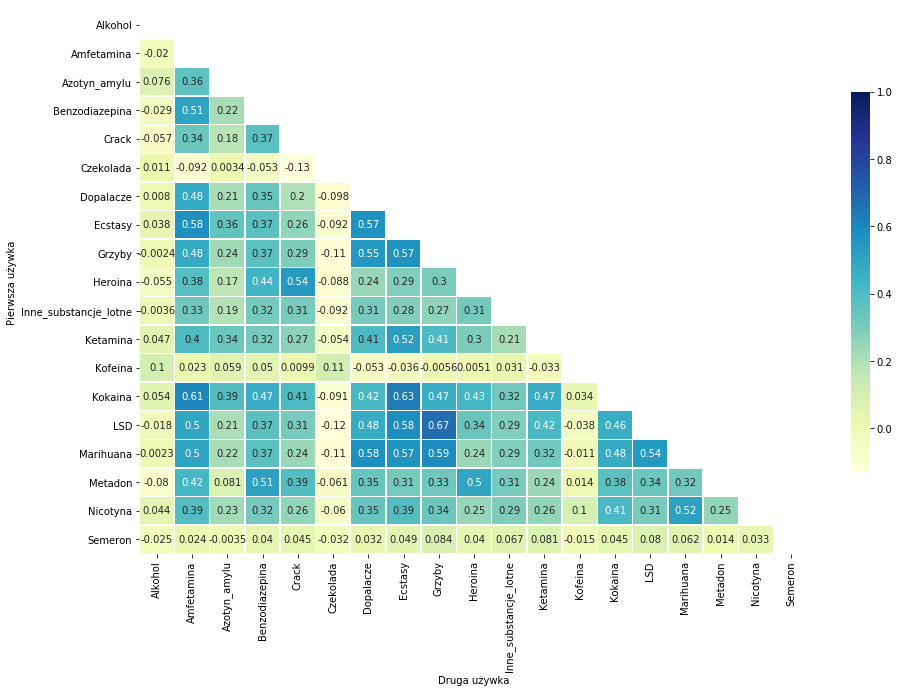

In [64]:
mask = np.zeros_like(to_heatmap, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(to_heatmap, mask=mask, cmap='YlGnBu', annot=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.xlabel('Druga używka')
plt.ylabel('Pierwsza używka')
plt.show()

### Drzewo decyzyjne w celu eksploracji danych

In [34]:
Y = data['Gender_mapped']
X = data.iloc[:, 12:31]

In [35]:
model = tree.DecisionTreeClassifier(max_depth=3)
model = model.fit(X, Y)
y_pred = model.predict(X)
print("Accuracy:", metrics.accuracy_score(Y, y_pred))

Accuracy: 0.6753315649867374


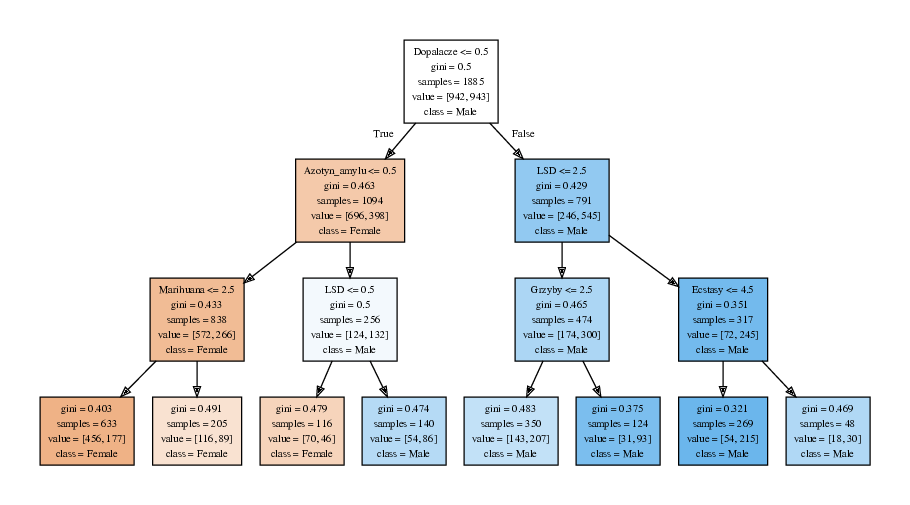

In [36]:
dot_data = tree.export_graphviz(model, out_file=None, feature_names = X.columns, class_names = Y, filled = True)
graph = graphviz.Source(dot_data) 
graph.render("drzewko")
WImage(filename='drzewko.pdf', height=1000, width=1000)

In [37]:
IFrame(src='plot2.html', width=1000, height=500)